In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import os
import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader
from spender import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange
from sbi import utils as Ut
from sbi import inference as Inference

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)
mpl.rcParams["mathtext.fontset"]='dejavuserif'

from generate_input import *

Starting dense_basis. Failed to load FSPS, only GP-SFH module will be available.


We generate a SFH, apply burst, obtain the spectra

In [72]:
n=1 #a single sfh
priors = db.Priors() #load priors from Dense Basis

curves=[]
times=[] #needed because rand_time length and step may vary (depends on the redshift)

z=np.zeros((n,)) #present time

priors.tx_alpha = 1
priors.ssfr_min = -50.0 #log(sfr/m)=log(sfr)-log(m)= -36 -14
priors.ssfr_max = 0.0 #log(sfr/m)=log(sfr)-log(m)= 10 - 10
priors.sfr_prior_type = 'sSFRflat'
priors.use_ssfr_prior = True


for i in range(n):
    rand_sfh_tuple=priors.sample_sfh_tuple()
    rand_sfh, rand_time = db.tuple_to_sfh(rand_sfh_tuple, zval = z[i]) 
    #save SFH
    curves.append(rand_sfh*1e9) #conversion from Msun/yr to Msun/Gyr
    times.append(rand_time)

ms=[]
#non-cumulative mass curves
for index,curve in enumerate(curves):        
    sfr_0=curve
    m=[]
    t=times[index]
    #print(t)
    step=t[1]-t[0]
    #print(step)
    for i,tx in enumerate(t):  
            m_t=sfr_0[i]*step #this gives directly the mass curve (non-cumulative)
            m.append(m_t)
    #plt.plot(t,m/np.sum(m))
    ms.append(m/np.sum(m)) #normalized (weigths)


#compute percentiles
percentiles=[]
for i,curve in enumerate(curves):
        mcurve=ms[i]
        m=[]
        percent=[]
        for j in range(len(mcurve)):
            m.append(np.sum(mcurve[:j+1]))
        for k in range(1,10):
            ind=np.argmin(abs(np.array(m)-k/10))
            percent.append(times[i][ind])
        percentiles.append(percent)  
    
t=np.copy(times)


In [73]:
z= [np.random.choice(np.linspace(-2.3,0.4,15))]
print('Loading MILES spectra and interpolating in metallicity: ')
tbins=get_tbins(dir_name='../MILES/MILES_BASTI_KU_baseFe',strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
wave,data_met=get_data_met(dir_name='../MILES/MILES_BASTI_KU',interpolate=True,z=z)

print('[M/H] = ',z)
data_extended=interpolate_t(tbins,t[0],data_met[:,:,0])
wave,seds=generate_all_spectrums(t[0],ms,wave,data_extended)

Loading MILES spectra and interpolating in metallicity: 
[M/H] =  [0.014285714285714235]


(1, 4300) (1, 1000)


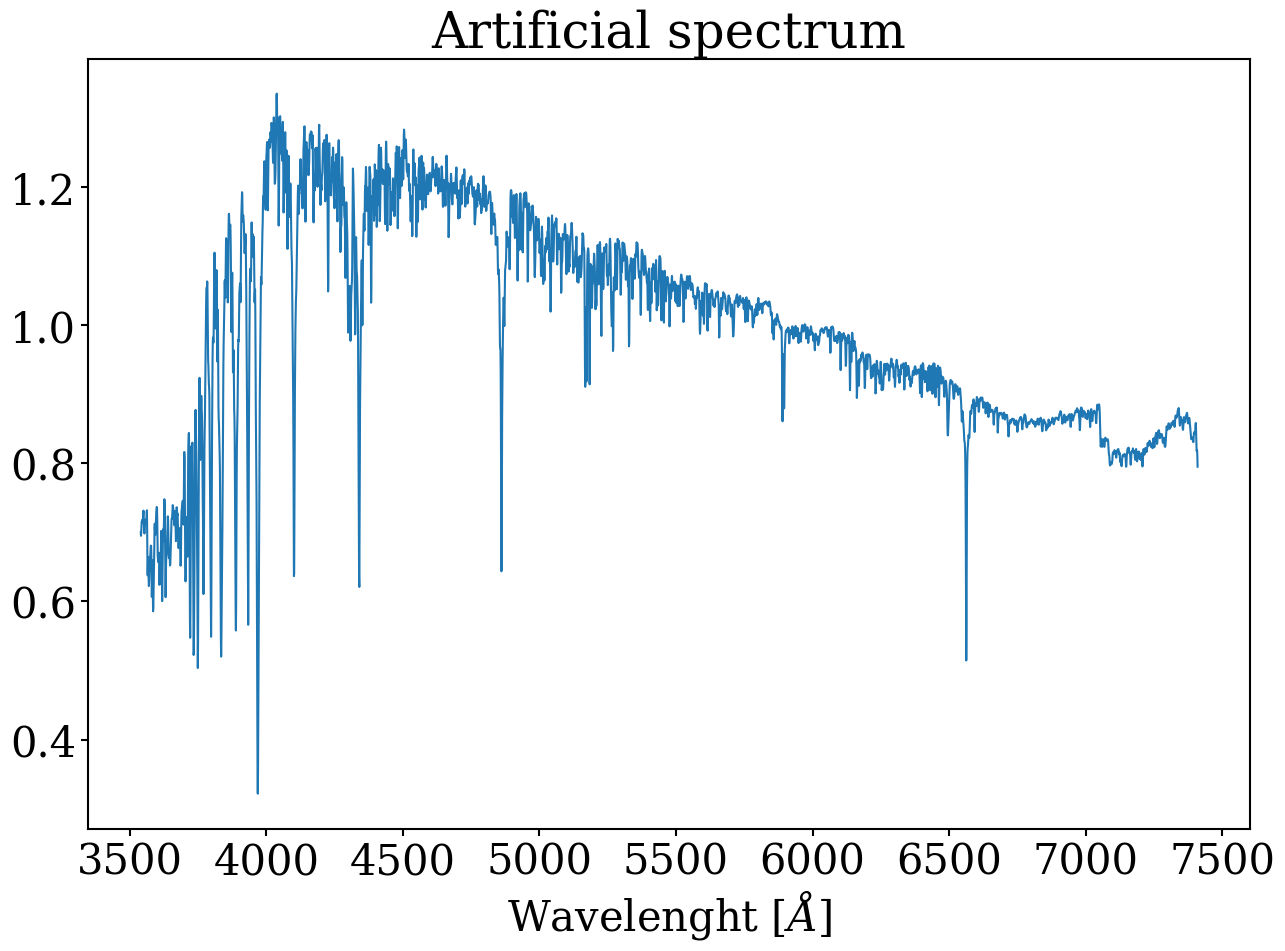

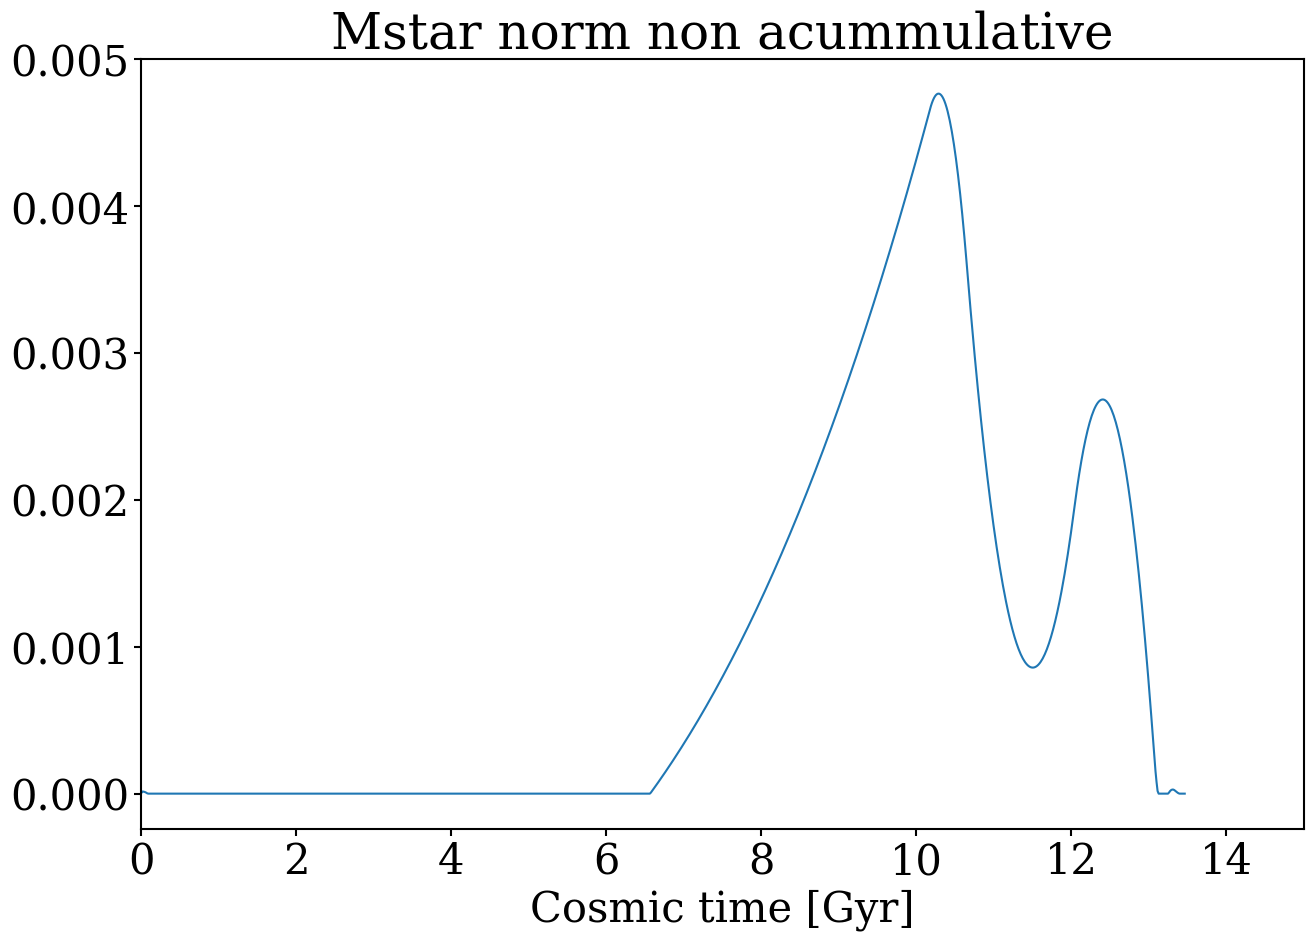

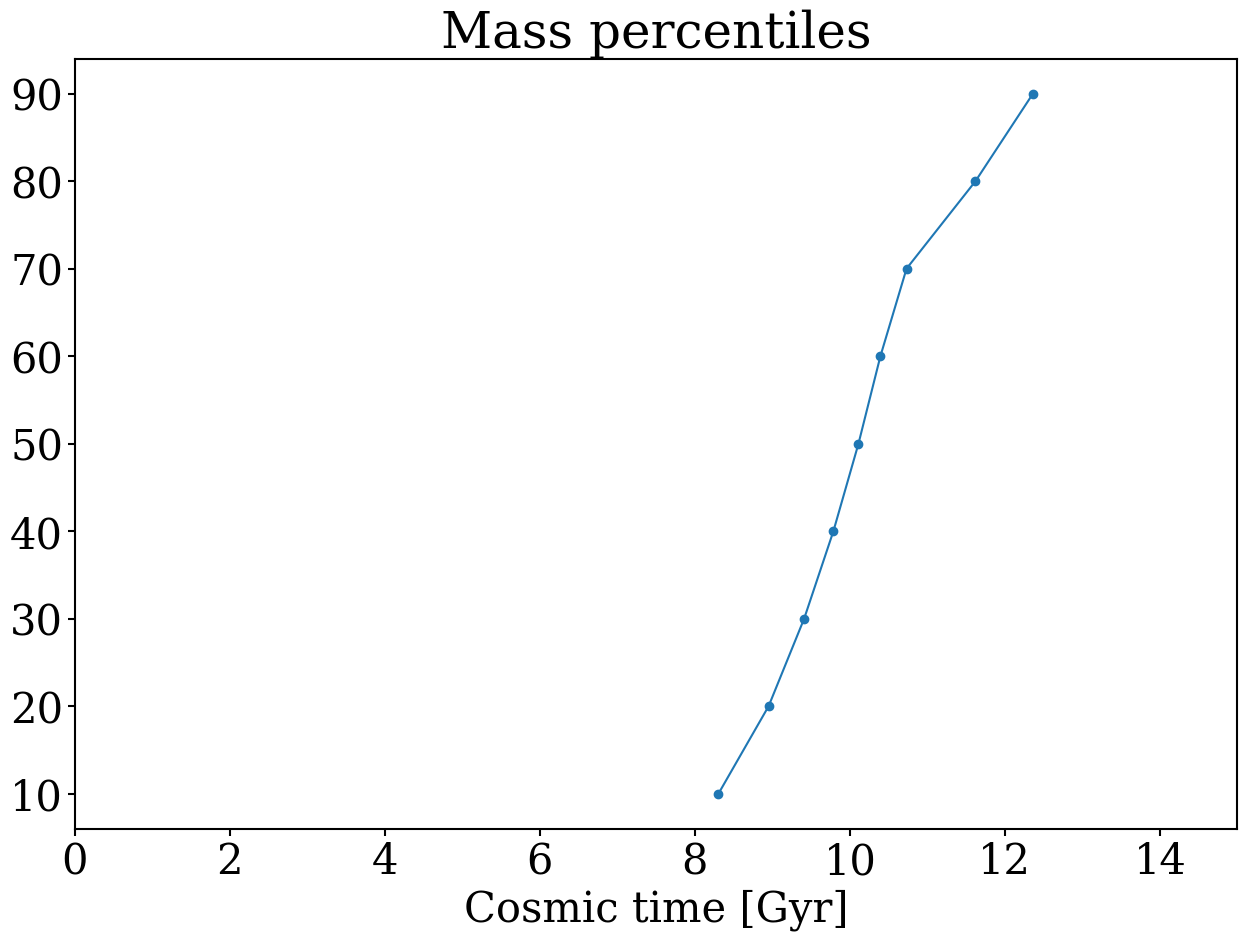

In [60]:
print(np.shape(seds),np.shape(ms))

plt.plot(wave,seds[0])
plt.xlabel('Wavelenght [$\\AA$]')
plt.title('Artificial spectrum')    
plt.show()


plt.plot(t[0],ms[0])
plt.xlim(0,15)
plt.xlabel('Cosmic time [Gyr]')
plt.title('Mstar norm non acummulative')
plt.show()


plt.plot(percentiles[0],np.arange(10,100,10),'o-')
plt.xlim(0,15)
plt.xlabel('Cosmic time [Gyr]')
plt.title('Mass percentiles')
plt.show()

In [74]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x):

        """ generate and organize data for training and testing"""

        self.x=torch.from_numpy(x) #seds
        

    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        return x

#create a pytorch dataset

dataset = Dataset(np.array(seds) )
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=10)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch.float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]


file="./saved_models/my_posterior.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

posteriors=[]


for i in tqdm(range(1)):
    posteriors.append(np.array(qphi.sample((100,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)

Getting latent vectors and predicted percentiles


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


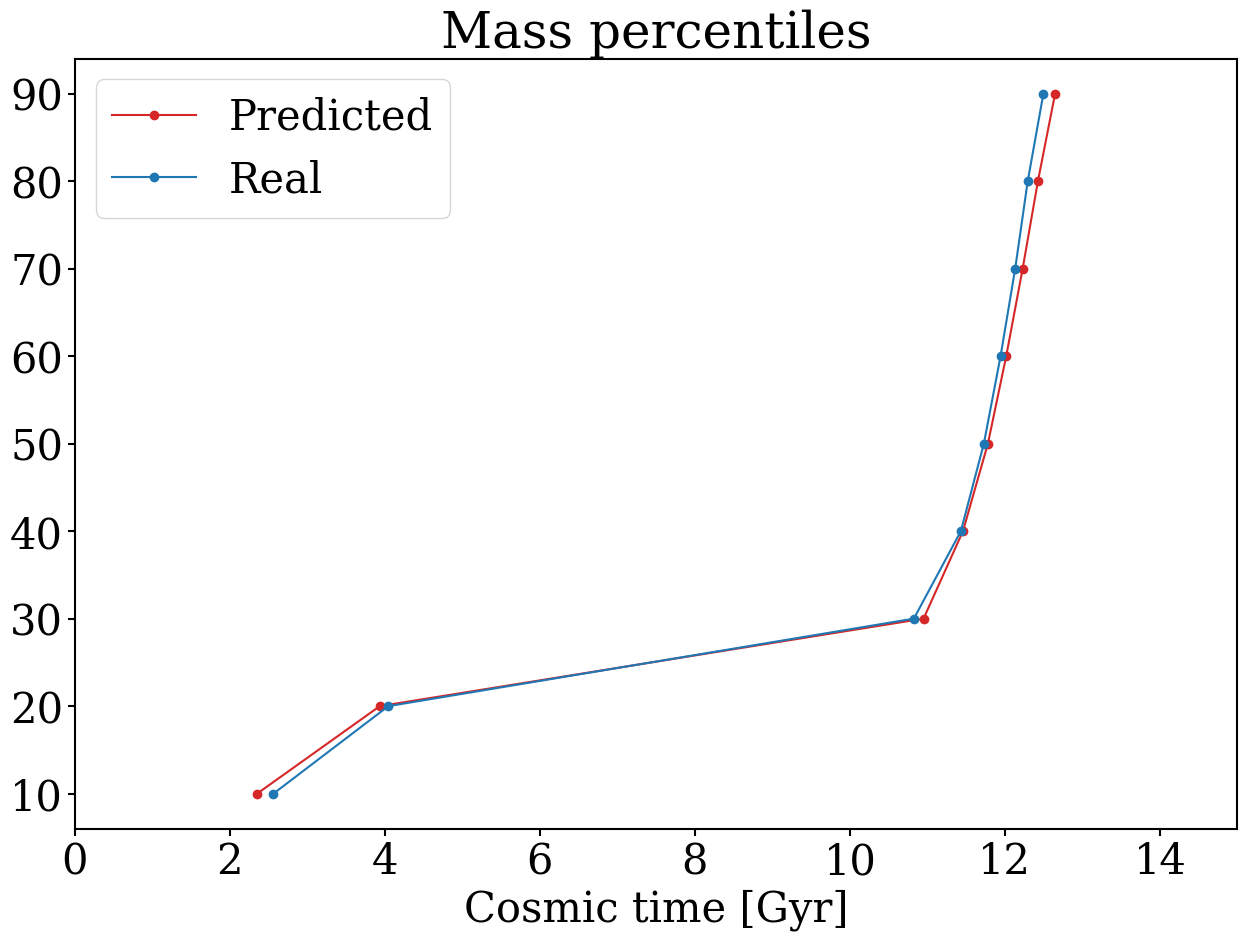

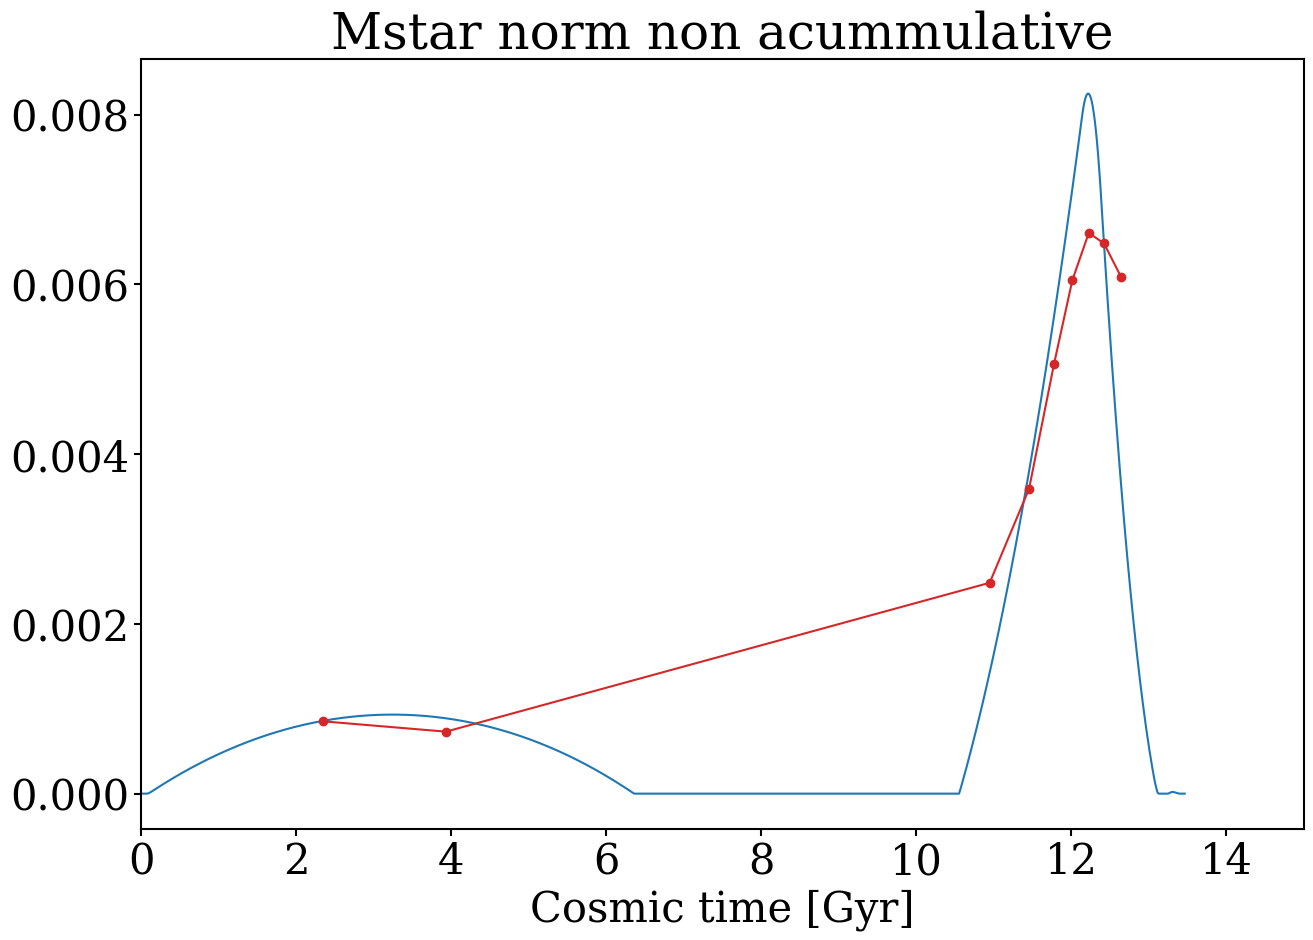

In [76]:
mean=np.median(posteriors,axis=1)
std = np.std(posteriors,axis=1)

plt.plot(mean[0,:-1],np.arange(10,100,10),'o-',color='tab:red',label='Predicted')
plt.plot(percentiles[0],np.arange(10,100,10),'o-',color='tab:blue',label='Real')
plt.xlim(0,15)
plt.xlabel('Cosmic time [Gyr]')
plt.title('Mass percentiles')
plt.legend()
plt.show()

delta_t=0.01348046441147335
ms_per=np.gradient(np.arange(0.1,1,0.1),mean[0,:-1]) *delta_t 

plt.plot(t[0],ms[0],'-',color='tab:blue',label='Real')
plt.plot(mean[0,:-1],ms_per,'o-',color='tab:red',label='Predicted')
plt.xlim(0,15)
plt.xlabel('Cosmic time [Gyr]')
plt.title('Mstar norm non acummulative')
plt.show()